# Geometry

## Description
The past several lectures have dealt with the geometry of imaging. In this project you will explore calibrating a camera with respect to 3D world coordinates as well as estimating the relationship between two camera views.

**Important Note on Implementation of this Notebook**

In this notebook, it tries its best to follow the implementation in the book, Multiple View Geometry in computer vision. Thus, there may be some inconsistency between the assignment description and the textbook. For example, the average distance from the origin of the normalized 2D points in `pts2d-norm-pic_a.txt` is 0.7785 and is 1.2147 for the normalized 3D points in `pts3d-norm.txt`. However, the suggested average distance in MVG is $\sqrt{2}$ for 2D points and $\sqrt{3}$ for 3D points. Thus, we follow MVG unless there is a strong reason not to.


In [1]:
import numpy as np
import csv
from scipy.optimize import least_squares
import random
from PIL import Image
from pathlib import Path
import geometry
import matplotlib.pyplot as plt
import cv2

projection_matrix_ground_truth = np.array(
    [
        [-0.4583, 0.2947, 0.0139, -0.0040],
        [0.0509, 0.0546, 0.5410, 0.0524],
        [-0.1090, -0.1784, 0.0443, -0.5968],
    ]
)  # (3, 4)
left_img_path = Path("./input/pic_a.jpg")
right_img_path = Path("./input/pic_b.jpg")

norm_pts2d_left_path = "./input/pts2d-norm-pic_a.txt"
unnorm_pts2d_left_path = "./input/pts2d-pic_a.txt"
unnorm_pts2d_right_path = "./input/pts2d-pic_b.txt"

norm_pts3d_path = "./input/pts3d-norm.txt"
unnorm_pts3d_path = "./input/pts3d.txt"

# 1. Calibration
The files `pts2d-pic_a.txt` and `pts3d.txt` are a list of twenty 2D and 3D points of the image `pic_a.jpg`. The goal is to compute the projection matrix that goes from world 3D coordinates to 2D image coordinates. Recall that using homogeneous coordinates the equation is:  
$$
\begin{bmatrix}
u \\
v \\
1 \\
\end{bmatrix}
\simeq
\begin{bmatrix}
s*u \\
s*v \\
s \\
\end{bmatrix}
=
\begin{bmatrix}
m_{11} & m_{12} & m_{13} & m_{14} \\
m_{21} & m_{22} & m_{23} & m_{24} \\
m_{31} & m_{32} & m_{33} & m_{34} \\
\end{bmatrix}
\begin{bmatrix}
X \\
Y \\
Z \\
1 \\
\end{bmatrix}
$$

Recall you solve for the 3x4 matrix M using either SVD to solve the homogeneous version of the equations or by setting $m_34$ to 1 and then using the a normal least squares method. Remember that M is only known up to a scale factor.
To make sure that your code is correct, we are going to give you a set of “normalized points” in the files `pts2d-norm-pic_a.txt` and `pts3d-norm.txt`. If you solve for M using all the points you should get a matrix that is a scaled equivalent of the following:  
$$
M_{normA}
=
\begin{bmatrix}
-0.4583 &  0.2947 & 0.0139 & -0.0040 \\
 0.0509 &  0.0546 & 0.5410 &  0.0524 \\
-0.1090 & -0.1784 & 0.0443 & -0.5968 \\
\end{bmatrix}
$$
For example, given a normalized 3D point, ${\begin{bmatrix}1.2323 & 1.4421 & 0.4506 & 1.0\end{bmatrix}}^T$, $M_{normA}$ will project this point to the ${\begin{bmatrix}u & v\end{bmatrix}}^T$ of ${\begin{bmatrix}0.1419 &  −0.4518\end{bmatrix}}^T$ where we converted the homogeneous 2D point ${\begin{bmatrix}us & vs & s\end{bmatrix}}^T$ to its inhomogeneous version by dividing by s (i.e. the real transformed pixel in the image). 



## Normalization
As MVG says, normalization of 2D and 3D points is a crucial step. In this notebook, we use $\sqrt{2}$ as the average distance from origin for 2D points and $\sqrt{3}$ as the average distance from origin for 3D points. We can use the ground truch projection matrix descirbed above to verify our normalization method is correct.

In [2]:


norm_left_pts2d = geometry.read_keypoints(norm_pts2d_left_path)
norm_pts3d = geometry.read_keypoints(norm_pts3d_path)
num_points = norm_left_pts2d.shape[1]
assert norm_left_pts2d.shape == (3, num_points)
assert norm_pts3d.shape == (4, num_points)
print(f"The average distance to origin is:")
print(f"2D: {geometry.average_distance_to_origin(norm_left_pts2d)}")
print(f"3D: {geometry.average_distance_to_origin(norm_pts3d)}")

avg_norm_dist_2d = 1 #  # geometry.average_distance_to_origin(norm_left_pts2d) # 
avg_norm_dist_3d = 1 #  # geometry.average_distance_to_origin(norm_pts3d) # 
print(f"Use {avg_norm_dist_2d} as average distance for 2D points.")
print(f"Use {avg_norm_dist_3d} as average distance for 3D points.")

norm_left_pts2d, norm_matrix_T = geometry.normalize_image_points(norm_left_pts2d, avg_distance=avg_norm_dist_2d)
norm_pts3d, norm_matrix_U = geometry.normalize_space_points(norm_pts3d, avg_distance=avg_norm_dist_3d)
print("Normalizing 2D and 3D points ...")
print("After normalization, the average distance to origin is:")
print(f"2D: {geometry.average_distance_to_origin(norm_left_pts2d)}")
print(f"3D: {geometry.average_distance_to_origin(norm_pts3d)}")

inverse_pts2d = np.dot(np.linalg.inv(norm_matrix_T), norm_left_pts2d)
inverse_pts3d = np.dot(np.linalg.inv(norm_matrix_U), norm_pts3d)
np.divide(inverse_pts2d, inverse_pts2d[-1, :], out=inverse_pts2d)
np.divide(inverse_pts3d, inverse_pts3d[-1, :], out=inverse_pts3d)
print("We can verify the correctness of normalization by applying the inverse of similarity transform to the normalized points.")
print(f"The denormalized 2D point: {inverse_pts2d[:, 0]}")
print(f"The denormalized 3D point: {inverse_pts3d[:, 0]}")

print(f"Now, we can use the normalized 2D points, normalized 3D points and the ground truth projection matrix to check if everything fits.")
print(f"The reprojected 2D point is {geometry.project_world_to_image(matrix=projection_matrix_ground_truth, pts3d=norm_pts3d)[:, 0]}.")
print(f"The normalized 2D points is {norm_left_pts2d[:, 0]}")
print(f"Notice that the value is not the same. Why?")

The average distance to origin is:
2D: 0.7784527834973538
3D: 1.2146912523900046
Use 1 as average distance for 2D points.
Use 1 as average distance for 3D points.
Normalizing 2D and 3D points ...
After normalization, the average distance to origin is:
2D: 1.0000000000000004
3D: 1.0
We can verify the correctness of normalization by applying the inverse of similarity transform to the normalized points.
The denormalized 2D point: [ 1.0486 -0.3645  1.    ]
The denormalized 3D point: [ 1.5706 -0.149   0.2598  1.    ]
Now, we can use the normalized 2D points, normalized 3D points and the ground truth projection matrix to check if everything fits.
The reprojected 2D point is [ 0.89153567 -0.32168408  1.        ].
The normalized 2D points is [ 1.34701861 -0.46823666  1.        ]
Notice that the value is not the same. Why?


We can observe that the reprojected 2D points and the normalized 2D points is not the same. The reason is that the ground truth projection matrix is associated with the points provided in `pts2d-norm-pic_a.txt` and `pts3d-norm.txt`. Thus, these points are different by a scaling factor.

In [3]:
print(geometry.project_world_to_image(matrix=projection_matrix_ground_truth, pts3d=norm_pts3d)[0, 0] / norm_left_pts2d[0, 0])
print(geometry.project_world_to_image(matrix=projection_matrix_ground_truth, pts3d=norm_pts3d)[0, 1] / norm_left_pts2d[0, 1])


0.6618584681707491
0.6378558016519478


## Create Projection Matrix
Create the least squares function that will solve for the 3x4 matrix `MnormA`  given the normalized 2D and 3D lists, namely `pts2d-norm-pic_a.txt` and `pts3d-norm.txt`. Test it on the normalized 3D points by multiplying those points by your M matrix and comparing the resulting the normalized 2D points to the normalized 2D points given in the file. Remember to divide by the homogeneous value to get an inhomogeneous point. You can do the comparison by checking the residual between the predicted location of each test point using your equation and the actual location given by the 2D input data. The residual is just the distance (square root of the sum of squared differences in u and v).

<img src="images/MVG-algo_7.1.png" style="width:512px;">


In [4]:
def direct_linear_transformation(pts2d: np.ndarray, pts3d: np.ndarray):
    # pts2d: (3, N), [u, v, 1]
    # pts3d: (4, N), [X, Y, Z, 1]
    assert pts2d.shape[0] == 3 and pts3d.shape[0] == 4
    assert pts2d.shape[1] == pts3d.shape[1]
    num_pts = pts2d.shape[1]
    A = np.zeros((2 * num_pts, 12))
    A[0::2, 0] = pts3d[0, :]
    A[0::2, 1] = pts3d[1, :]
    A[0::2, 2] = pts3d[2, :]
    A[0::2, 3] = 1

    A[1::2, 4] = pts3d[0, :]
    A[1::2, 5] = pts3d[1, :]
    A[1::2, 6] = pts3d[2, :]
    A[1::2, 7] = 1

    A[0::2, 8] = -1 * np.multiply(pts2d[0, :], pts3d[0, :])
    A[1::2, 8] = -1 * np.multiply(pts2d[1, :], pts3d[0, :])
    A[0::2, 9] = -1 * np.multiply(pts2d[0, :], pts3d[1, :])
    A[1::2, 9] = -1 * np.multiply(pts2d[1, :], pts3d[1, :])
    A[0::2, 10] = -1 * np.multiply(pts2d[0, :], pts3d[2, :])
    A[1::2, 10] = -1 * np.multiply(pts2d[1, :], pts3d[2, :])
    A[0::2, 11] = -1 * pts2d[0, :]
    A[1::2, 11] = -1 * pts2d[1, :]

    eigenvalues, eigenvectors = np.linalg.eig(np.dot(A.T, A))
    min_arg = np.argmin(eigenvalues)
    return eigenvectors[:, min_arg]


def geometric_error(m, pts2d, pts3d):
    # m: (12,)
    # norm_pts2d: (3, N)
    # norm_pts3d: (4, N)
    num_points = pts3d.shape[1]
    M = np.reshape(m, (3, 4))

    assert pts2d.shape[0] == 3 and pts2d.shape[1] == num_points
    assert pts3d.shape[0] == 4 and pts3d.shape[1] == num_points

    predicted_2d_pts = np.dot(M, pts3d)  # (3,4) x (4,N) -> (3,N)
    assert predicted_2d_pts.shape[0] == 3 and predicted_2d_pts.shape[1] == num_points
    predicted_2d_pts = np.divide(predicted_2d_pts, predicted_2d_pts[2, :])
    assert predicted_2d_pts.shape[0] == 3 and predicted_2d_pts.shape[1] == num_points

    sum = np.sum((pts2d - predicted_2d_pts) ** 2, axis=0)
    return np.sum(sum)  # (3,N) -> scalar

def generate_projection_matrix(norm_pts2d, norm_pts3d):
    m0 = direct_linear_transformation(norm_pts2d, norm_pts3d)
    res_1 = least_squares(geometric_error, m0, args=(norm_pts2d, norm_pts3d))
    return res_1.x, res_1.cost

def denormalize_projection_matrix(T, P, U):
    tmp = np.dot(np.linalg.inv(T), np.dot(np.reshape(P, (3, 4)), U))
    return tmp.flatten()

In [5]:
unnorm_left_pts2d = geometry.read_keypoints(unnorm_pts2d_left_path)
unnorm_pts3d = geometry.read_keypoints(unnorm_pts3d_path)
norm_left_pts2d, norm_matrix_T = geometry.normalize_image_points(unnorm_left_pts2d, avg_distance=avg_norm_dist_2d)
norm_pts3d, norm_matrix_U = geometry.normalize_space_points(unnorm_pts3d, avg_distance=avg_norm_dist_3d)

norm_project_mat, err = generate_projection_matrix(norm_pts2d=norm_left_pts2d, norm_pts3d=norm_pts3d)
unnorm_project_mat = denormalize_projection_matrix(T=norm_matrix_T, P=norm_project_mat, U=norm_matrix_U)

print(geometry.project_world_to_image(matrix=unnorm_project_mat, pts3d=unnorm_pts3d)[:, 0])


[879.3689283  214.74503297   1.        ]


b. Now you are ready to calibrate the camera. Using the 3D and 2D point lists for the image, we’re going to compute the camera projection matrix. To understand the effects of over constraining the system, you’re going to try using sets of 8, 12 and 16 points and then look at the residuals. To debug your code you can use the normalized set from above but for the actual question you’ll need to use: pts2d-pic_b.txt and pts3d.txt 

In [6]:



# denormP = denormalize_projection_matrix(T=matrix_T, P=MnormA, U=matrix_U)
# projected_pts_2d = project_3D_to_2D(denormP, unnorm_pts3d)

# print(projected_pts_2d.shape)
# print(projected_pts_2d[:, -1])


In [7]:
# unnorm_pts2d = np.loadtxt("./input/pts2d-norm-pic_a.txt")  # (N, 2)
# unnorm_pts3d = np.loadtxt("./input/pts3d-norm.txt")  # (N, 3)
# num_points = unnorm_pts2d.shape[0]

# tmp = np.ones((1, num_points))
# unnorm_pts3d = np.concatenate((unnorm_pts3d.T, tmp), axis=0)  # (4, N)
# unnorm_pts2d = np.concatenate((unnorm_pts2d.T, tmp), axis=0)  # (3, N)

# norm_pts2d, matrix_T = normalize_image_points(unnorm_pts2d, avg_distance=avg_dist_2d)
# norm_pts3d, matrix_U = normalize_space_points(unnorm_pts3d, avg_distance=avg_dist_3d)
# MnormA, err = generate_projection_matrix(norm_pts2d, norm_pts3d)
# print(MnormA.shape, err)

Now you are ready to calibrate the cameras. Using the 3D and 2D point lists for the image, we’re going to compute the camera projection matrix. To understand the effects of overconstraining the system, you’re going to try using sets of 8, 12 and 16 points and then look at the residuals. To debug your code you can used the normalized set from above but for the actual question you’ll need to use the `./pts2d-pic_b.txt` and `./pts3d.txt`.

1.2 For the three point set sizes k of 8, 12, and 16, repeat 10 times:
1. Randomly choose k points from the 2D list and their corresponding points in the 3D
list.
2. Compute the projection matrix M on the chosen points.
3. Pick 4 points not in your set of k and compute the average residual.
4. Save the M that gives the lowest residual.
Output: code that does the computation, and the average residual for each trial of each k (so
that would be 10 x 3 = 30 numbers). Explain any difference you see between the results for
the different k.
Output: Best M

In [8]:


# unnorm_pts2d = np.loadtxt("./input/pts2d-pic_a.txt")  # (N, 2)
# unnorm_pts3d = np.loadtxt("./input/pts3d.txt")  # (N, 3)
# num_points = unnorm_pts2d.shape[0]

# tmp = np.ones((1, num_points))
# unnorm_pts2d = np.concatenate((unnorm_pts2d.T, tmp), axis=0)  # (3, N)
# unnorm_pts3d = np.concatenate((unnorm_pts3d.T, tmp), axis=0)  # (4, N)

# norm_pts2d, similarity_matrix_T = normalize_image_points(unnorm_pts2d, avg_distance=avg_dist_2d)

# inverse_pts2d = np.dot(np.linalg.inv(similarity_matrix_T), norm_pts2d)
# print("inverse_pts2d: ", inverse_pts2d[:, 0])
# inverse_pts2d = np.divide(inverse_pts2d, inverse_pts2d[-1, :])
# print("inverse_pts2d: ", inverse_pts2d[:, 0])

# # print("Normalized image points:")
# # print(norm_pts2d.shape, norm_pts2d[:, 0])
# # print(average_distance_to_origin(norm_pts2d))
# # print("unnorm_pts2d[:, -1]: ", unnorm_pts2d[:, -1])
# # tmp = np.dot(
# #         similarity_matrix_T, unnorm_pts2d[:, 0]
# #     )
# # print(
# #     tmp / tmp[-1]
# # )

# # print("Normalized space points:")
# # print(norm_pts3d.shape, norm_pts3d[:, 0])
# # print(average_distance_to_origin(norm_pts3d))
# # print(
# #     np.dot(
# #         similarity_matrix_U, norm_pts3d[:, 0]
# #     )
# # )

In [9]:
# def Denormalization(T, P, U):
#     tmp = np.dot(np.linalg.inv(T), np.dot(np.reshape(P, (3, 4)), U))
#     return tmp.flatten()

# unnorm_pts2d = np.loadtxt("./input/pts2d-pic_a.txt")  # (N, 2)
# unnorm_pts3d = np.loadtxt("./input/pts3d.txt")  # (N, 3)
# num_points = unnorm_pts2d.shape[0]

# tmp = np.ones((1, num_points))
# unnorm_pts2d = np.concatenate((unnorm_pts2d.T, tmp), axis=0)  # (3, N)
# unnorm_pts3d = np.concatenate((unnorm_pts3d.T, tmp), axis=0)  # (4, N)

# norm_pts2d, similarity_matrix_T = normalize_image_points(unnorm_pts2d, avg_distance=avg_dist_2d)
# norm_pts3d, similarity_matrix_U = normalize_space_points(unnorm_pts3d, avg_distance=avg_dist_3d)

# inverse_pts2d = np.dot(np.linalg.inv(similarity_matrix_T), norm_pts2d)
# print("inverse_pts2d: ", inverse_pts2d[:, 0])
# inverse_pts2d = np.divide(inverse_pts2d, inverse_pts2d[-1, :])
# print("inverse_pts2d: ", inverse_pts2d[:, 0])

# inverse_pts3d = np.dot(np.linalg.inv(similarity_matrix_U), norm_pts3d)
# print("inverse_pts3d: ", inverse_pts3d[:, 0])
# inverse_pts3d = np.divide(inverse_pts3d, inverse_pts3d[-1, :])
# print("inverse_pts3d: ", inverse_pts3d[:, 0])

# print(norm_pts2d.shape)
# assert norm_pts2d.shape[1] == norm_pts3d.shape[1]

# total_num_pts = norm_pts2d.shape[1]
# selected_num_pts = [8, 12, 16]
# selected_num_pts = [ 16]

# print("total_num_pts: ", total_num_pts)
# print(average_distance_to_origin(norm_pts2d))
# print(average_distance_to_origin(norm_pts3d))
# print("hello")

# iteration = 10
# for i in range(iteration):
#     for k in selected_num_pts:
#         training_indices = random.sample(range(total_num_pts), k)
#         remaining_points = [x for x in range(total_num_pts) if x not in training_indices]
#         testing_indices = random.sample(remaining_points, 4)
#         # print(training_indices, testing_indices)
        
#         # MnormA, err = generate_projection_matrix(norm_pts2d[:, training_indices], norm_pts3d[:, training_indices])
#         MnormA, err = generate_projection_matrix(norm_pts2d, norm_pts3d)
        
#         print(" MnormA, err: ", err)
#         projected_pts_2d = project_3D_to_2D(matrix=MnormA, pts3d=norm_pts3d)
#         print("normalized projected pts2d: ", projected_pts_2d[:, 0])


#         denorm_P = Denormalization(similarity_matrix_T, MnormA, similarity_matrix_U)
#         # print("denorm_P: ", denorm_P.shape)
        
#         # print(unnorm_pts3d.shape)
#         projected_pts_2d = project_3D_to_2D(matrix=denorm_P, pts3d=unnorm_pts3d)
#         print(projected_pts_2d[:, 0])


In [10]:
# tmp = np.reshape(MnormA, (3, 4))
# Q = tmp[:, :3]
# m4 = tmp[:, -1]
# camera_center = -1 * np.dot(np.linalg.inv(Q), m4)
# print(camera_center)

# tmp = np.reshape(denorm_P, (3, 4))
# Q = tmp[:, :3]
# m4 = tmp[:, -1]
# camera_center = -1 * np.dot(np.linalg.inv(Q), m4)
# print(camera_center)

Finally we can solve for the camera center in the world. Let us define M as being made up of a 3x3 we’ll call Q and a 4 th column will call m4:

M = [Q|m 4 ]

From class we said that the center of the camera C could be found by:
To debug your code: If you use you the normalized 3D points to get the M normA given above you
would get a camera center of:


C normA =< −1.5125, −2.3515, 0.2826 >


Given the best M from the last part, compute C

# 2. Fundamental Matrix Estimation
We now wish to estimate the mapping of points in one image to lines in another by means of the
fundamental matrix. This will require you to use similar methods to those in Problem 1. We will
make use of the corresponding point locations listed in pts2d-pic_a.txt and pts2d-pic_b.txt.
Recall that the definition of the Fundamental Matrix is
$$
\begin{bmatrix}
u^{\prime} & v^{\prime} & 1
\end{bmatrix}
\begin{bmatrix}
f_{11} & f_{12} & f_{13} \\
f_{21} & f_{22} & f_{23} \\
f_{31} & f_{32} & f_{33} \\
\end{bmatrix}
\begin{bmatrix}
u \\
v \\
1 \\
\end{bmatrix}
= 0$$



Given corresponding points you get one equation per point pair. With 8 or more points you can
solve this. With more points (such as the 20 in the files) you solve using the the same least squares
method as in problem 1 above.


Create the least squares function that will solve for the 3x3 matrix F̃ that satisfies the epipolar
constraints defined by the sets of corresponding points. Solve this function to create your
least squares estimate of the 3x3 transform F̃ .
Output: code that does the solving. The matrix F̃ generated from your least squares function.

<img src="images/MVG-algo_11.1.png" style="width:512px;">


In [11]:
def denormalize_fundamental_matrix(T_prime, F, T):
    return np.dot(np.dot(T_prime.T, F), T)


def compose_A(num_points, pts2d_left, pts2d_right):
    assert pts2d_left.shape == (3, num_points)
    assert pts2d_right.shape == (3, num_points)
    tmp = np.zeros((num_points, 9))
    # FIXME: Use dot product. It's less prone to typo.
    tmp[:, 0] = np.multiply(pts2d_left[0, :], pts2d_right[0, :])
    tmp[:, 1] = np.multiply(pts2d_left[1, :], pts2d_right[0, :])
    tmp[:, 2] = pts2d_right[0, :]
    tmp[:, 3] = np.multiply(pts2d_left[0, :], pts2d_right[1, :])
    tmp[:, 4] = np.multiply(pts2d_left[1, :], pts2d_right[1, :])
    tmp[:, 5] = pts2d_right[1, :]
    tmp[:, 6] = pts2d_left[0, :]
    tmp[:, 7] = pts2d_left[1, :]
    tmp[:, 8] = 1

    return tmp


def least_squares_fundamental_matrix(f, pts2d_left, pts2d_right):
    # pts2d_left: (3, N)
    # pts2d_right: (3, N)
    # f must be 1D
    assert f.shape == (9,)
    num_points = pts2d_left.shape[1]
    assert pts2d_left.shape == (3, num_points)
    assert pts2d_right.shape == (3, num_points)
    tmp = np.zeros((num_points, 9))
    tmp[:, 0] = np.multiply(pts2d_left[0, :], pts2d_right[0, :])
    tmp[:, 1] = np.multiply(pts2d_left[1, :], pts2d_right[0, :])
    tmp[:, 2] = pts2d_right[0, :]
    tmp[:, 3] = np.multiply(pts2d_left[0, :], pts2d_right[1, :])
    tmp[:, 4] = np.multiply(pts2d_left[1, :], pts2d_right[1, :])
    tmp[:, 5] = pts2d_right[1, :]
    tmp[:, 6] = pts2d_left[0, :]
    tmp[:, 7] = pts2d_left[1, :]
    tmp[:, 8] = 1

    return np.sum(np.dot(tmp, f[:, None]), axis=1)


def constrain_fundamental_matrix(f):
    u, s, vh = np.linalg.svd(f, full_matrices=True)

    D_head = np.array([[s[0], 0, 0], [0, s[1], 0], [0, 0, 0]])

    return np.dot(np.dot(u, D_head), vh.T)


unnorm_left_pts2d = geometry.read_keypoints(unnorm_pts2d_left_path)
unnorm_right_pts2d = geometry.read_keypoints(unnorm_pts2d_right_path)
num_points = unnorm_left_pts2d.shape[1]

norm_pts2d_left, similarity_mat_T = geometry.normalize_image_points(
    unnorm_left_pts2d, avg_distance=np.sqrt(2)
)
norm_pts2d_right, similarity_mat_T_prime = geometry.normalize_image_points(
    unnorm_right_pts2d, avg_distance=np.sqrt(2)
)

# init_f = np.ones((9))
# least_squares_fundamental_matrix(init_f, norm_pts2d_left, norm_pts2d_right)

# res_1 = least_squares(
#     least_squares_fundamental_matrix, init_f, args=(norm_pts2d_left, norm_pts2d_right)
# )
# print(res_1.x / res_1.x[-1])

print(norm_pts2d_left.shape)
A = compose_A(num_points, norm_pts2d_left, norm_pts2d_right)
print("A.shape: ", A.shape)
eigenvalues, eigenvectors = np.linalg.eig(np.dot(A.T, A))
min_arg = np.argmin(eigenvalues)
print("np.dot(A, eigenvectors[:, min_arg]): \n", np.dot(A, eigenvectors[:, min_arg]))
init_f = np.reshape(eigenvectors[:, min_arg], (3, 3))


constrained_f = constrain_fundamental_matrix(init_f)
print("constrained_f: \n", constrained_f)
# constrained_f = constrained_f / constrained_f[2, 2]

print(
    "is it zeros:", np.dot(np.dot(norm_pts2d_right.T, constrained_f), norm_pts2d_left)
)


constrained_f_forward = denormalize_fundamental_matrix(
    T_prime=similarity_mat_T_prime, F=constrained_f, T=similarity_mat_T
)

constrained_f_backward = denormalize_fundamental_matrix(
    T_prime=similarity_mat_T_prime, F=constrained_f.T, T=similarity_mat_T
)
# constrained_f = denormalize_fundamental_matrix(
#     T_prime=similarity_mat_T, F=constrained_f, T=similarity_mat_T_prime
# )


# print("is it zeros:", np.dot(np.dot(unnorm_right_pts2d.T, constrained_f), unnorm_left_pts2d))

(3, 20)
A.shape:  (20, 9)
np.dot(A, eigenvectors[:, min_arg]): 
 [-0.00336847 -0.00248519  0.00053341  0.00113474  0.00124893  0.00081556
 -0.00030771  0.00428237  0.0012655   0.00123571  0.00436079  0.00050441
  0.00481047 -0.0015586  -0.00763698 -0.00252738 -0.00111555  0.00261658
 -0.00181209 -0.00199345]
constrained_f: 
 [[ 0.00556338 -0.05117962 -0.01265409]
 [-0.03928622  0.03419782 -0.7183973 ]
 [-0.08065987  0.68552209  0.04399185]]
is it zeros: [[-5.47532259e-03  2.06860606e-01  1.15813520e-01  4.88096360e-01
   3.63155973e-01 -3.44867261e-01  1.51728435e+00  1.34040697e-01
   6.15600643e-01  1.16736900e+00  9.83091008e-01  8.60406196e-01
   6.13876460e-01  5.74861050e-01  8.84827502e-01  5.45364522e-01
   8.78169471e-01  1.76455454e-01  3.94280777e-01 -2.19094067e-02]
 [-1.90909161e-01  1.36986033e-01  2.81694597e-03  4.76160101e-01
   3.14099497e-01 -6.52873893e-01  1.88771520e+00  2.01999693e-02
   6.76291861e-01  1.39962944e+00  1.17717471e+00  9.90334070e-01
   6.57486892

In [12]:
unnorm_left_pts2d.shape

(3, 20)

The linear squares estimate of F̃ is full rank; however, the fundamental matrix is a rank 2
matrix. As such we must reduce its rank. In order to do this we can decompose F̃ using
singular value decomposition into the matrices U ΣV T = F̃ . We can then estimate a rank 2
matrix by setting the smallest singular value in Σ to zero thus generating Σ 0 . The fundamental
matrix is then easily calculated as F = U Σ 0 V T . Use the SVD function to do, well, the SVD.
Duh.

height, width:  712 1072
y1:  [208.36607895 284.17056056 248.14160748 348.07688534 315.8830335
 118.86266225 735.94372479 252.20916169 418.56363234 567.24244616
 563.38160316 476.49364894 397.17643844 397.35421991 507.17196389
 371.11717107 502.68017121 264.02850142 326.17966404 203.38735412]


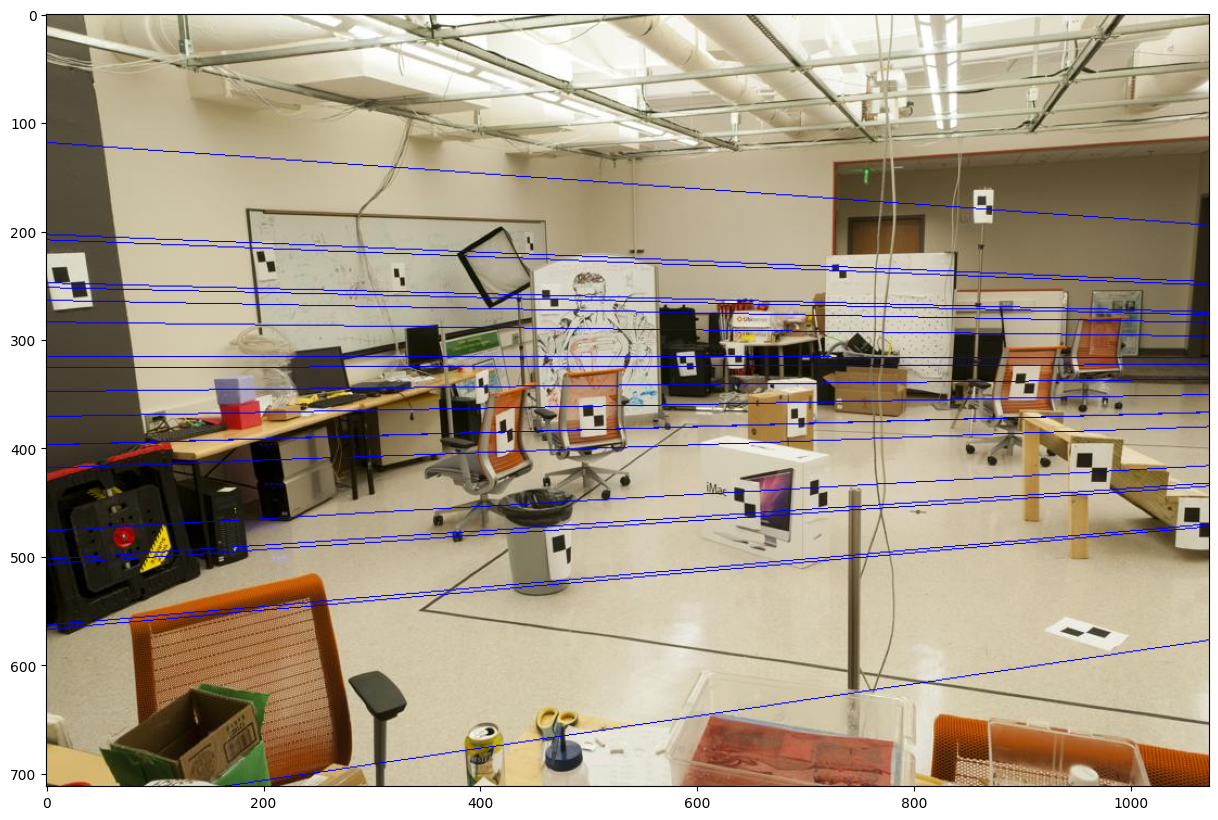

In [13]:


left_img_path = Path("./input/pic_a.jpg")
right_img_path = Path("./input/pic_b.jpg")

with Image.open(left_img_path) as im:
    left_img = np.asarray(im).copy()
with Image.open(right_img_path) as im:
    right_img = np.asarray(im).copy()

# tmp = np.dot(np.linalg.inv(similarity_mat_T_prime), norm_pts2d_right)
geometry.draw_epipolar_line_in_image(left_points=unnorm_left_pts2d[:, :], right_image=right_img, fundamental_matrix=constrained_f_forward, colour=geometry.blue)
plt.figure(figsize = (15, 15))
plt.imshow(right_img)

# tmp = np.dot(np.linalg.inv(similarity_mat_T), norm_pts2d_left)
# geometry.draw_epipolar_line_in_image(left_points=unnorm_left_pts2d[:, 6][:, None], right_image=right_img, fundamental_matrix=constrained_f, colour=geometry.blue)
# geometry.draw_epipolar_line_in_imagew(left_points=unnorm_left_pts2d[:, 5:8], right_image=right_img, fundamental_matrix=constrained_f, colour=geometry.blue)

# plt.imshow(right_img)

height, width:  712 1072
y1:  [183.33446067 204.85068039 188.66388579 284.40299288 256.14833828
 114.56138013 501.02217184 197.37015006 309.76410227 419.52159057
 394.87069449 362.03475886 308.15523051 300.93292748 371.57534848
 294.93193881 368.91917765 210.97069458 262.68845644 168.83158768]


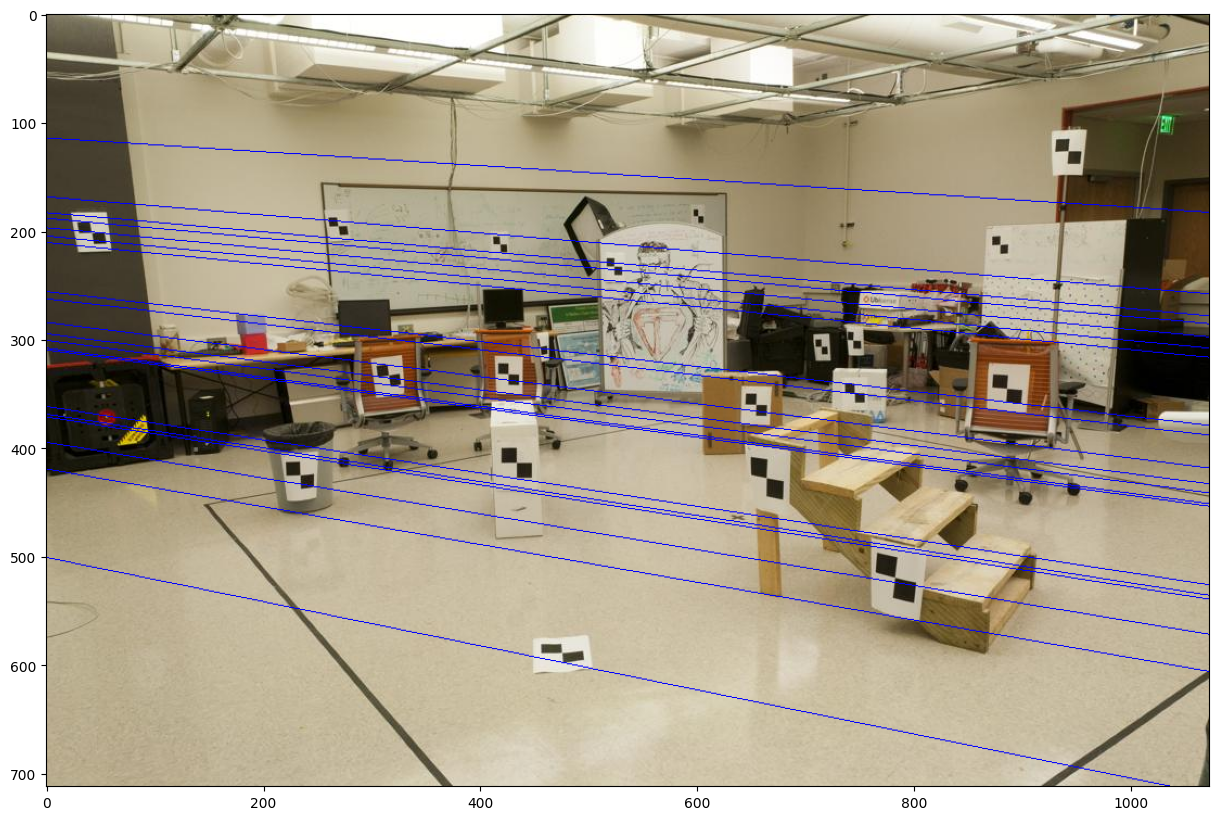

In [14]:
geometry.draw_epipolar_line_in_image(left_points=unnorm_right_pts2d[:, :], right_image=left_img, fundamental_matrix=constrained_f_backward, colour=geometry.blue)
plt.figure(figsize = (15, 15))
plt.imshow(left_img)


### Rectify the stereo images

